<a href="https://colab.research.google.com/github/AlekseiMikhalev/Data-Science-Projects/blob/master/Fellowship.ai_ULMFiT_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#__ULMFiT tweets sentiment analysis__
This analysis is prepared as one of the challenges of Fellowship.ai. The original link to the challenge is here https://fellowship.ai/challenge.

The challenge is to make an analysis of the dataset that includes tweets about several airlines and build a classification model by using ULMFiT pre-trained neural network. The aim is to build a classification model that can do sentimental analysis of tweets and show which of them are negative, positive or neutral. 

The dataset has been downloaded from [here](https://www.kaggle.com/crowdflower/twitter-airline-sentiment#Tweets.csv).

In [0]:
# Importing Libraries
# In this analysis I am using fast.ai library because the ULMFiT model is a main part of this library 

from fastai.metrics import accuracy # fast.ai metrics for measuring accuracy
from fastai.text import * 
from fastai import * # import fast.ai library
import gc 
import os 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import matplotlib.pyplot as plt # library for data visualization 

In [47]:
# Open the dataset from csv file and quickly explore it
tweets = pd.read_csv('/content/Tweets.csv')
print('Shape: ', tweets.shape) # check the shape of the dataframe
tweets.head()

Shape:  (14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [48]:
# Calculate the percentage of null values in each column and sort in descending order
print("The percentage of null or na values in the dataset")
((tweets.isnull() | tweets.isna()).sum() * 100 / tweets.index.size).round(2).sort_values(ascending=False)

The percentage of null or na values in the dataset


negativereason_gold             99.78
airline_sentiment_gold          99.73
tweet_coord                     93.04
negativereason                  37.31
user_timezone                   32.92
tweet_location                  32.33
negativereason_confidence       28.13
tweet_created                    0.00
text                             0.00
retweet_count                    0.00
name                             0.00
airline                          0.00
airline_sentiment_confidence     0.00
airline_sentiment                0.00
tweet_id                         0.00
dtype: float64

In [0]:
# I want to drop the top 3 columns with the highest percentage of missing values (more than 90%), because it will be impossible to restore them
tweets = tweets.drop(columns=['airline_sentiment_gold', 'negativereason_gold', 'tweet_coord'])

###__Data visualization__

I want to make some visualization to represent the data in more convenient way that will probably help me to find interesting insights
 
*Visualize the total number of tweets per each airlines*

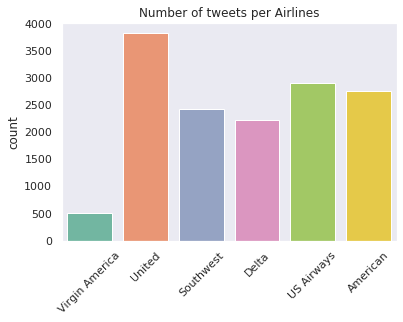

In [50]:
import seaborn as sns

# set graph style
sns.set(palette='Set2', style='dark')

# plot tweets distribution per each airlines
sns.countplot(tweets.airline)
plt.title('Number of tweets per Airlines')
plt.tick_params(axis='x', rotation=45)
plt.xlabel('')
plt.show()

__Conclusion 1:__ United has more tweets than the other airlines, and Virgin America has the lowest number of tweets 

*Tweet sentiments per each airlines*

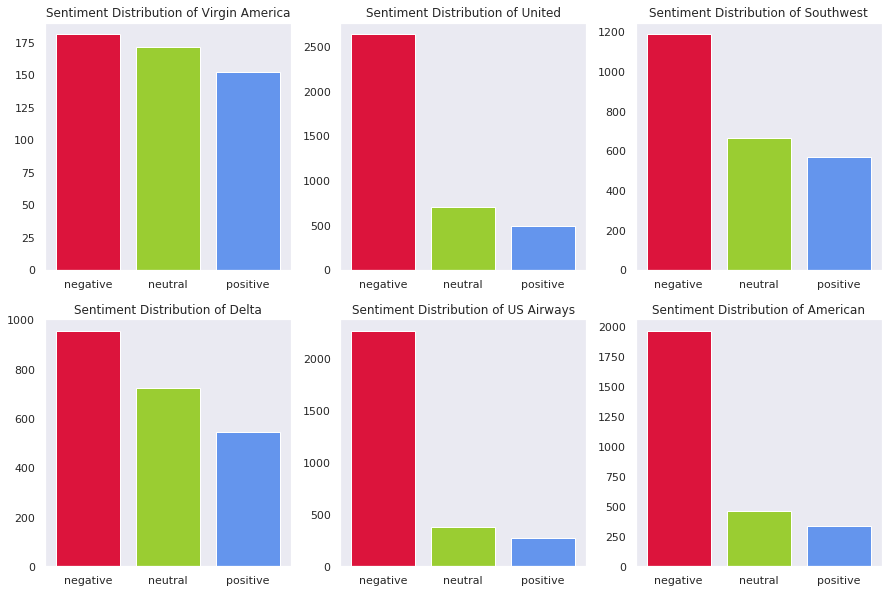

In [51]:
# Let's plot bar charts that show the number of tweets in each sentiment group by airlines

plt.figure(1, figsize=(15,10))
custom_palette = ["#DC143C", "#9ACD32", "#6495ED"]
airlines = list(tweets['airline'].unique())
for i in tweets.airline.unique():
    idx = airlines.index(i)
    plt.subplot(2,3,idx+1)
    pl_df = tweets[tweets.airline==i]
    count = pl_df['airline_sentiment'].value_counts()
    index = [1,2,3]
    plt.bar(index, count, color=custom_palette)
    plt.xticks(index, ['negative','neutral','positive'])
    
    plt.ylabel('')
    plt.title('Sentiment Distribution of ' + i)


    

__Conclusion 2:__ 
* All airlines have negative, positive and neutral tweets, and the number of negative tweets is prevailed. 
* Tweets "basket" of Virgin America is relatively balanced. The numbers of negative, positive and neutral tweets are not significantly different compare to other airlines. 
* The highest number of negative tweets have United airline and US Airways, and clients tend to tweet more about these two companies based on the total number of tweets

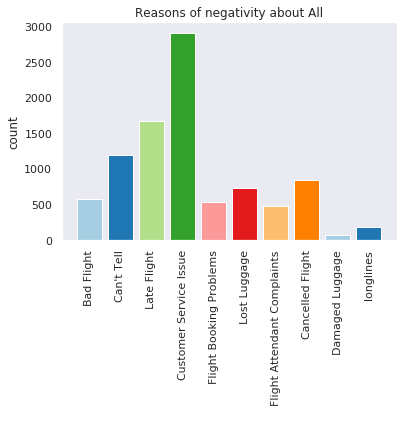

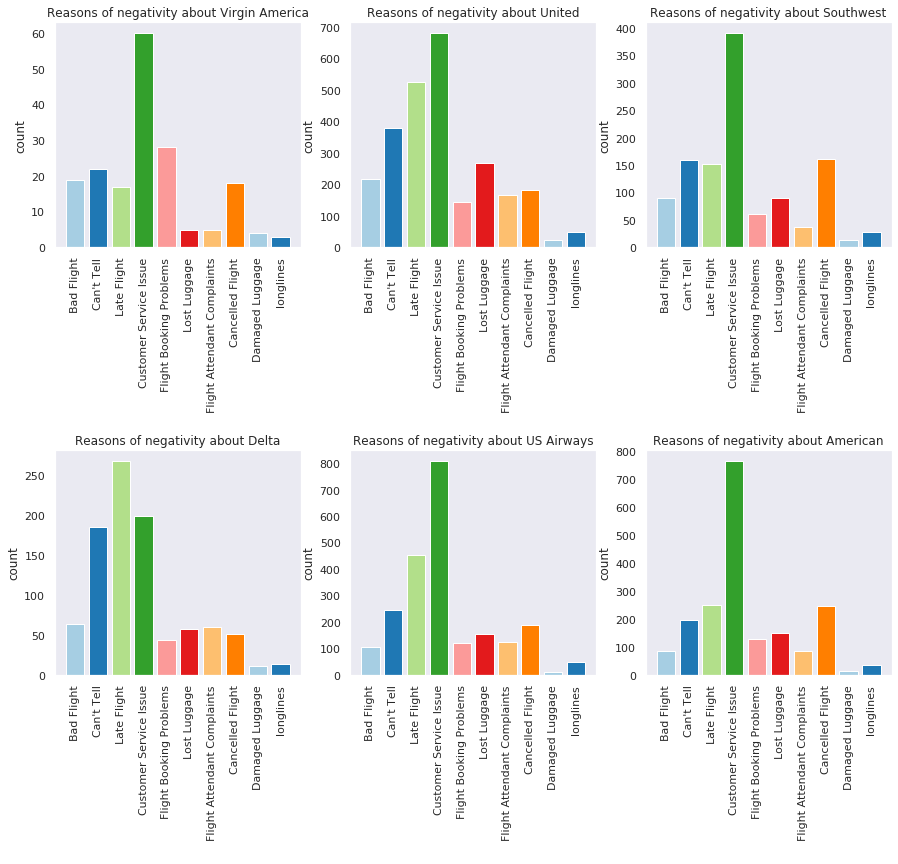

In [52]:
# Let's plot the reasons of negativity for all airlines and for each of them

tweets['negativereason'].nunique()
custome_palette2 = sns.color_palette("Paired", 8)

nr_count = dict(tweets['negativereason'].value_counts(sort=False))
def reason_count(airline):
    if airline=='All':
        a = tweets
    else:
        a = tweets[tweets['airline']==airline]
    count = dict(a['negativereason'].value_counts())
    unique_reason=list(tweets['negativereason'].unique())
    unique_reason=[x for x in unique_reason if str(x) != 'nan']
    reason_frame=pd.DataFrame({'reasons':unique_reason})
    reason_frame['count']=reason_frame['reasons'].apply(lambda x: count[x])
    return reason_frame

def plot_reason(airline):
    a = reason_count(airline)
    count = a['count']
    index = range(1, (len(a)+1))
    plt.bar(index, count, color=custome_palette2)
    plt.xticks(index, a['reasons'], rotation=90)
    plt.ylabel('count')
    plt.xlabel(' ')
    plt.title('Reasons of negativity about ' + airline)
    
plot_reason('All')
plt.figure(2,figsize=(15, 12))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2, 3, indices+1)
    plt.subplots_adjust(hspace=0.9)
    plot_reason(i)

__Conclusion 3:__ We can see that the major reason for negativity is 'Customer Service Issue'. It is the main reson for all airlines, except for Delta. Delta's main reason is flight delays. 'Customer Service Issue' is quite a broad definition, and based on that we cannot say what is the exact problem of negativity

###__Wordclouds__ of the __Positive__, __Negative__, __Neutral__ airline_sentiment

In order to get quick understanding of the mood of clients who wrote tweets we can have a look at the most frequent words that they used 

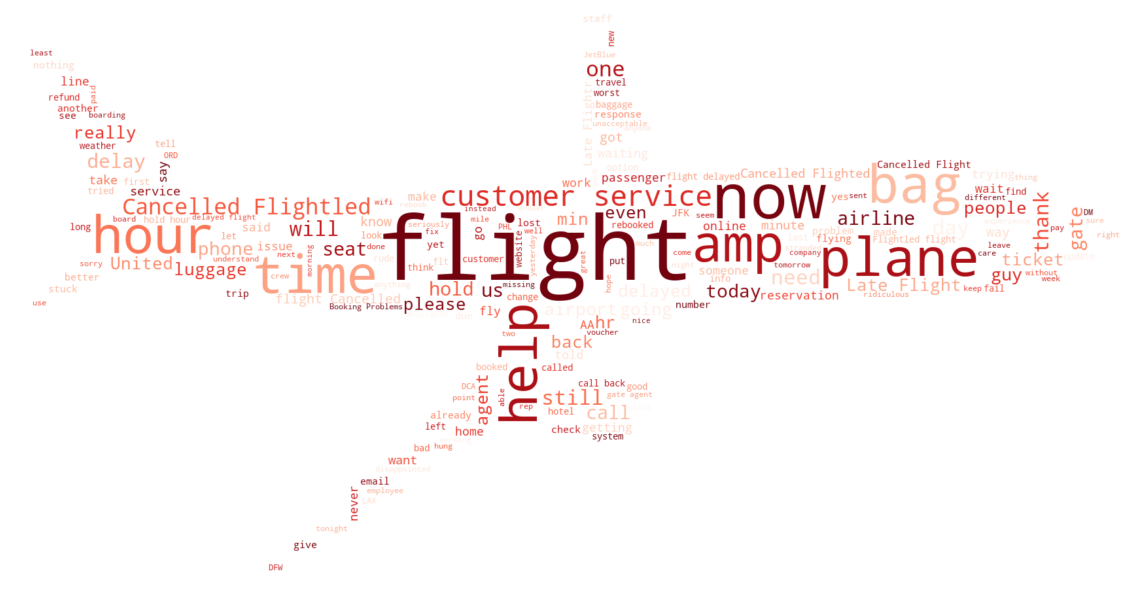

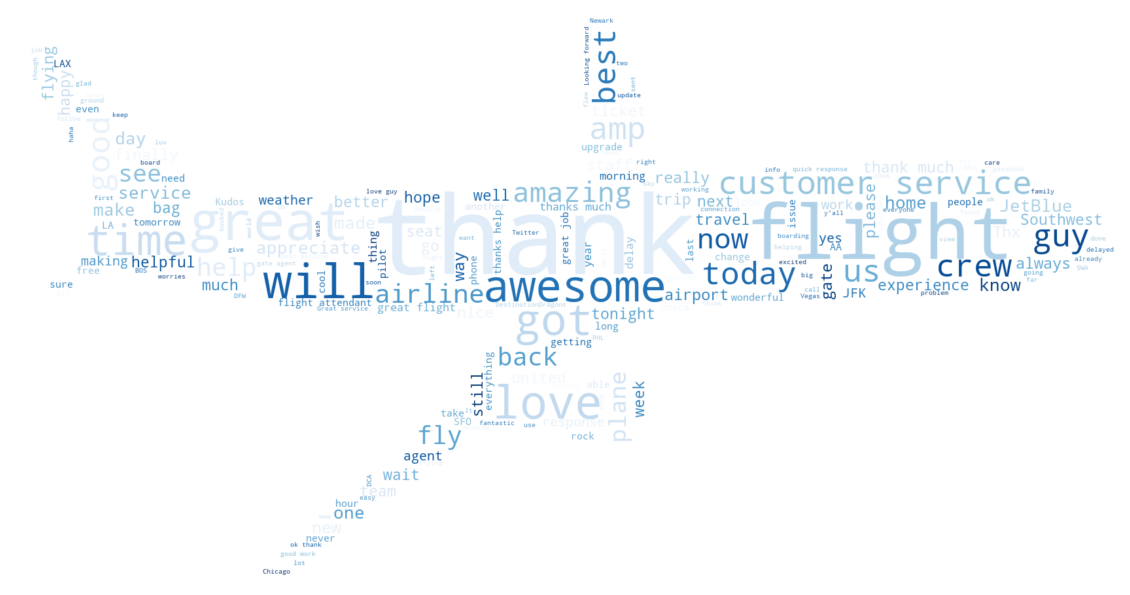

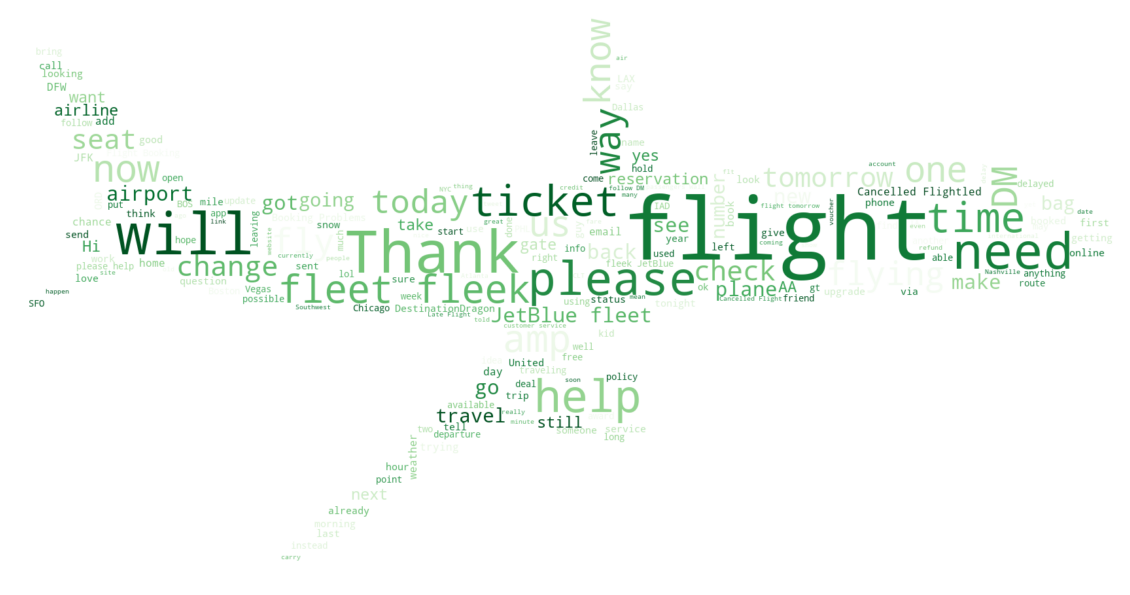

In [53]:
from wordcloud import WordCloud,STOPWORDS  # WordCloud is used for data visualization. The size of each word indicates its frequency or importance.
from PIL import Image # to import the image for the shape 
wave_mask = np.array(Image.open( "/content/airbus.jpg"))

# Positive sentiments
words_positive = ' '.join(tweets[tweets['airline_sentiment']=='positive']['text'])
cleaned_word_positive = " ".join([word for word in words_positive.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
# Negative sentiments
words_negative = ' '.join(tweets[tweets['airline_sentiment']=='negative']['text'])
cleaned_word_negative = " ".join([word for word in words_negative.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
# Neutral sentiments
words_neutral = ' '.join(tweets[tweets['airline_sentiment']=='neutral']['text'])
cleaned_word_neutral = " ".join([word for word in words_neutral.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud_negative = WordCloud(stopwords=STOPWORDS, mask=wave_mask, background_color='white', colormap="Reds",  width=2048, height=2048).generate(cleaned_word_negative)
plt.figure(1,figsize=(20, 14))
plt.imshow(wordcloud_negative, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()
wordcloud_positive = WordCloud(stopwords=STOPWORDS, mask=wave_mask, background_color='white', colormap="Blues", width=2048, height=2048).generate(cleaned_word_positive)
plt.figure(1,figsize=(20, 14))
plt.imshow(wordcloud_positive, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()
wordcloud_neutral = WordCloud(stopwords=STOPWORDS, mask=wave_mask, background_color='white', colormap="Greens", width=2048, height=2048).generate(cleaned_word_neutral)
plt.figure(1,figsize=(20, 14))
plt.imshow(wordcloud_neutral, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

__Conclusion 4:__ 
* For _negative_ tweets clients use the following most frequent words: flight, flight cancelled, delay, late flight, bag, lugage, etc. That makes sense, so we can hypothesis that the main 'Customer Service Issues' can be related to flight delays and luggage issues (lost luggage, delays with luggage delivery, broked luggage, etc.) 
* For _positive_ tweets the most frequent words are: thank, flight, awesome, apreciate, time,love, etc. Nothing special, to be honest.
* For _neutral_ tweets: flight, thank, change, help, please, way, today, etc. Frankly speaking, we can only hypothesise that customers suggest some improvements to airlines' services

The interesting thing is that some words are the same for negative, positive and neutral tweets

In [54]:
# Just to have a look at the frequent words from another angle, I want to play a bit with text and visualize it in a different way
# I am using NLTK for text processing

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [55]:
negative_tokenized_tweets = [] # tokenize tweets and save them for further processing
positive_tokenized_tweets = []
neutral_tokenized_tweets = []
negative = cleaned_word_negative.split()
positive = cleaned_word_positive.split()
neutral = cleaned_word_neutral.split()
from nltk import flatten

for i in negative: 
  tokens = nltk.word_tokenize(i)
  negative_tokenized_tweets.append(tokens)
negative_tokenized_tweets = flatten(negative_tokenized_tweets)

for i in positive: 
  tokens = nltk.word_tokenize(i)
  positive_tokenized_tweets.append(tokens)
positive_tokenized_tweets = flatten(positive_tokenized_tweets)

for i in neutral: 
  tokens = nltk.word_tokenize(i)
  neutral_tokenized_tweets.append(tokens)
neutral_tokenized_tweets = flatten(neutral_tokenized_tweets)

print(negative_tokenized_tweets[0:9])
print(positive_tokenized_tweets[0:9])
print(neutral_tokenized_tweets[0:9])

['it', "'s", 'really', 'aggressive', 'to', 'blast', 'obnoxious', '``', 'entertainment']
['plus', 'you', "'ve", 'added', 'commercials', 'to', 'the', 'experience', '...']
['What', 'said', '.', 'I', 'did', "n't", 'today', '...', 'Must']


In [56]:
# Remove stopwords and punctuation from the lists of tweets

import string
negative_without_stopwords = []
positive_without_stopwords = []
neutral_without_stopwords = []

for w in negative_tokenized_tweets:
  if w not in stop_words | set(string.punctuation):
    negative_without_stopwords.append(w)

for w in positive_tokenized_tweets:
  if w not in stop_words | set(string.punctuation):
    positive_without_stopwords.append(w)

for w in neutral_tokenized_tweets:
  if w not in stop_words | set(string.punctuation):
    neutral_without_stopwords.append(w)

print('Negative \n', negative_without_stopwords[0:9],'\n Positive \n', positive_without_stopwords[0:9],'\n Neutral \n', neutral_without_stopwords[0:9])

Negative 
 ["'s", 'really', 'aggressive', 'blast', 'obnoxious', '``', 'entertainment', "''", 'guests'] 
 Positive 
 ['plus', "'ve", 'added', 'commercials', 'experience', '...', 'tacky', 'yes', 'nearly'] 
 Neutral 
 ['What', 'said', 'I', "n't", 'today', '...', 'Must', 'mean', 'I']


In [57]:
from collections import Counter 
freq_negative = Counter(negative_without_stopwords)
freq_positive = Counter(positive_without_stopwords)
freq_neutral = Counter(neutral_without_stopwords)

# Create dataframes in pandas with two columns and sort it by frequency

freq_negative = pd.DataFrame(freq_negative.most_common(50), columns=['words_negative', 'count'])
freq_negative.sort_values(ascending=False, by='count')

freq_positive = pd.DataFrame(freq_positive.most_common(50), columns=['words_positive', 'count'])
freq_positive.sort_values(ascending=False, by='count')

freq_neutral = pd.DataFrame(freq_neutral.most_common(50), columns=['words_neutral', 'count'])
freq_neutral.sort_values(ascending=False, by='count')

print('Negative \n', freq_negative.head(), '\n Positive \n', freq_positive.head(), '\n Neutral \n', freq_neutral.head())

Negative 
   words_negative  count
0              I   4318
1         flight   2336
2            n't   1759
3            get    949
4      Cancelled    920 
 Positive 
   words_positive  count
0              I    713
1         flight    326
2         thanks    320
3         Thanks    283
4          Thank    231 
 Neutral 
   words_neutral  count
0             I   1315
1        flight    495
2            's    359
3           get    235
4           n't    199


It seems that we have many of "I" in the data sets, however it doesn't have any values, so let's get rid of it too


In [58]:
stopword = "I"
for w in negative_without_stopwords:
  if w in stopword:
    negative_without_stopwords.remove(w)

for w in positive_without_stopwords:
  if w in stopword:
    positive_without_stopwords.remove(w)

for w in neutral_without_stopwords:
  if w in stopword:
    neutral_without_stopwords.remove(w)

# Create counter again
freq_negative = Counter(negative_without_stopwords)
freq_positive = Counter(positive_without_stopwords)
freq_neutral = Counter(neutral_without_stopwords)

# Create dataframes again
freq_negative = pd.DataFrame(freq_negative.most_common(50), columns=['words_negative', 'count'])
freq_negative.sort_values(ascending=False, by='count')

freq_positive = pd.DataFrame(freq_positive.most_common(50), columns=['words_positive', 'count'])
freq_positive.sort_values(ascending=False, by='count')

freq_neutral = pd.DataFrame(freq_neutral.most_common(50), columns=['words_neutral', 'count'])
freq_neutral.sort_values(ascending=False, by='count')

print('Negative \n', freq_negative.head(), '\n Positive \n', freq_positive.head(), '\n Neutral \n', freq_neutral.head())

Negative 
   words_negative  count
0         flight   2336
1            n't   1759
2            get    949
3      Cancelled    920
4             's    903 
 Positive 
   words_positive  count
0         flight    326
1         thanks    320
2         Thanks    283
3          Thank    231
4          thank    204 
 Neutral 
   words_neutral  count
0        flight    495
1            's    359
2           get    235
3           n't    199
4           ...    182


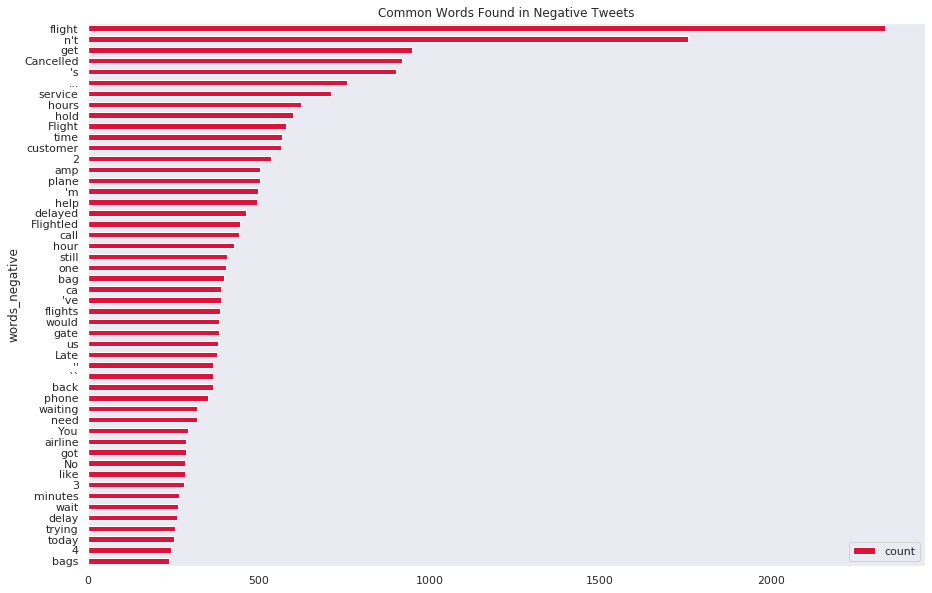

In [59]:
# Let's plot the results to check it visually
fig, ax = plt.subplots(figsize=(15, 10))

# Plot horizontal bar graph
# For negative words

freq_negative.sort_values(by='count').plot.barh(x='words_negative', y='count', ax=ax, color="#DC143C")
ax.set_title("Common Words Found in Negative Tweets")
plt.show()

We can see that the words 'flight' and 'cancelled' is quite frequent

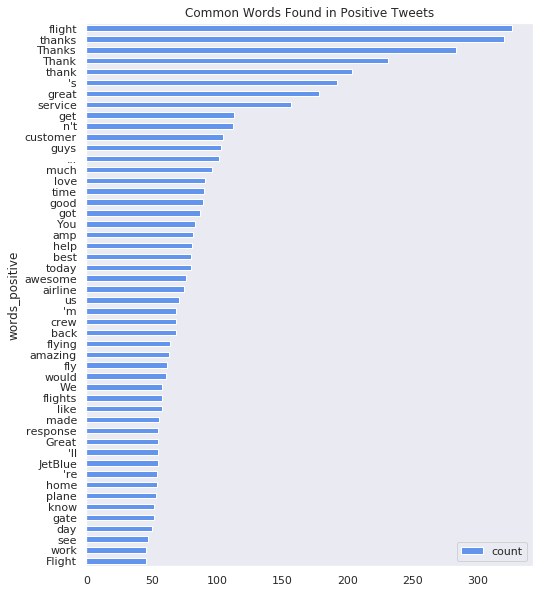

In [60]:
# For positive words
fig, ax = plt.subplots(figsize=(8, 10))
freq_positive.sort_values(by='count').plot.barh(x='words_positive', y='count', ax=ax, color="#6495ED")
ax.set_title("Common Words Found in Positive Tweets")
plt.show()

As usual, nothing special from positive tweets

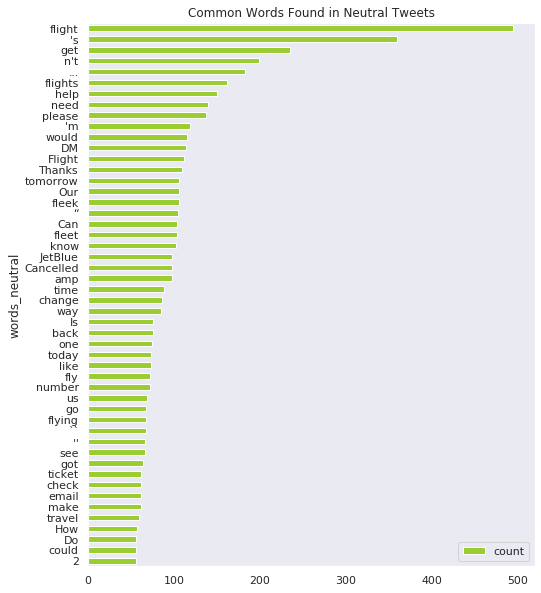

In [61]:
#For neutral words
fig, ax = plt.subplots(figsize=(8, 10))
freq_neutral.sort_values(by='count').plot.barh(x='words_neutral', y='count', ax=ax, color="#9ACD32")
ax.set_title("Common Words Found in Neutral Tweets")
plt.show()

Neutral frequent words have some similarities with positive and negative tweets which might add some noise into our model

###__Explore if there are any relashionships between time and tweets__

The idea to check potential relashionships between dates and tweets about different airlines came to my mind occasionally. There can be various reasons behind that, and time-series analysis can be useful. However, I decided just to have a look at that and do not over my analysis.  

In [62]:
date = tweets.reset_index()
# convert the Date column to pandas datetime
date.tweet_created = pd.to_datetime(date.tweet_created)

# Reduce the dates in the date column to only the date and no time stamp using the 'dt.date' method
date.tweet_created = date.tweet_created.dt.date
date.tweet_created.head()
tweets = date
day_df = tweets.groupby(['tweet_created','airline','airline_sentiment']).size()
day_df


tweet_created  airline         airline_sentiment
2015-02-16     Delta           negative               1
                               neutral                1
               United          negative               2
2015-02-17     Delta           negative             108
                               neutral               86
                                                   ... 
2015-02-24     United          neutral               49
                               positive              25
               Virgin America  negative              10
                               neutral                6
                               positive              13
Length: 136, dtype: int64

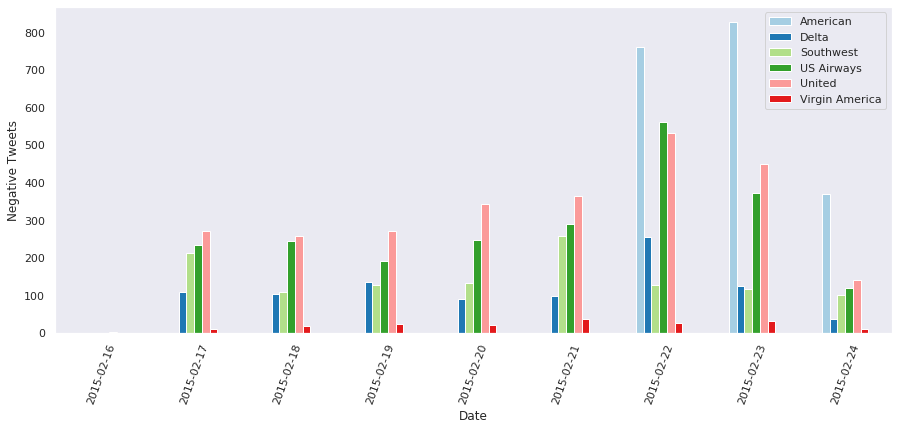

In [63]:
#Now we can plot it and see if we can get any interesting insights about negative tweets

day_df = day_df.loc(axis=0)[:, :, 'negative']

#Groupby and plot data
ax2 = day_df.groupby(['tweet_created','airline']).sum().unstack().plot(kind = 'bar', color=custome_palette2, figsize = (15, 6), rot = 70)
labels = ['American','Delta','Southwest','US Airways','United','Virgin America']
ax2.legend(labels = labels)
ax2.set_xlabel('Date')
ax2.set_ylabel('Negative Tweets')
plt.show()

__Conclusion 5:__ Hmm...that looks interesting, the total number of tweets increased on Feb 22-23. Another interesting observation is that the tweets about American Airlines appeared and for these two days there is surge of tweets about this airline. Go to Google and after 5 minutes news searching we can find that in 2015 _"American Airlines (AAL), which merged with US Airways, attracted the most complaints, while discount carrier Spirit (SAVE) drew the most grievances on a per-passenger basis._ (source: https://fortune.com/2016/02/18/airline-complaints-passengers/). That explains increasing number of tweets. 

###__Data Cleaning for ULMFiT__

Now, let's start to work with ULMFiT for building our classification model.
![image.png](https://humboldt-wi.github.io/blog/img/seminar/group4_ULMFiT/Figure_3.png)

Source: https://humboldt-wi.github.io/blog/research/information_systems_1819/group4_ulmfit/

Since ULMFiT model is already trained on the WikiText-103 dataset, there is a list of all unique tokens in the dataset, ordered from most often to least often used as well as the same information formatted as a dictionary. Thus loading this vocabulary and dictionary enables us to encode our tweets text accordingly.

AWD-LSTM has to be rebuilt in order to be able to load in the weights of the trained model the ULMFiT's authors provided online. The preparation of the tweets dataset involves:
  * data cleaning (e.g. the removal of links),
  * splitting into train and test datasets,
  * tokenization (include adding meta-data tokens such as: indication of the beginning and the end of a sentence, capitalization and ALL CAPS spelling), and
  * encoding of all tweets.

Basically we need to focus on two main things:
* __Tokenization__, which meant splitting the raw texts into tokens (which can be words, or punctuation signs...). 

* __Numericalization__, which means that we are attributing a unique id to each token and mapping each of those tokens to their respective ids. 

## __Tokenization__

In [64]:
# Let's check the text of our tweets and decide what we can clean

tweets_preprocessed = tweets[['airline_sentiment','text']]
tweets_preprocessed.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [65]:
# Split the dataset into train and test datasets

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# Split data into training and test set
train, test = train_test_split(tweets_preprocessed, test_size = 0.2, random_state = 678)

# Print lengths
print(len(train), len(test), sum([len(train), len(test)]))

11712 2928 14640


### Batchnig

In [66]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = train, valid_df = test, path = "")
data_lm.save()
data_lm.show_batch()

idx,text
0,/ xxunk xxbos @southwestair my bag was xxmaj late xxmaj flight - checked and put on a different flight from xxup xxunk . xxmaj having troubles tracking it down . xxmaj any help ? xxbos @united thank you for listening to my xxunk and doing the right thing . i appreciate you working with me xxbos @southwestair no self help way to put in tsa pre check number for existing
1,"xxunk ) on flight xxunk to xxmaj seattle has a tray table that is falling off ... http : / / t.co / xxunk xxbos @united xxmaj after an hour+ wait , my issue is resolved . i did contact customer service to comment on the wait time . xxmaj thanks for contacting me . xxbos @americanair xxmaj thank you , you too ! xxbos @jetblue as a customer it"
2,"23 agent this am who boarded flight xxunk to xxup dal . xxmaj did n't get his name . xxmaj he represents your brand so well . xxbos @usairways - xxmaj good to know that your phone customer service is still xxunk due to "" bad weather "" that was over a week ago # xxunk ? xxbos @southwestair i wish i would 've known so i could 've slept"
3,"of customer service . xxunk xxup est and no one can answer ? 2 / 2 xxbos @jetblue xxmaj finally taking off ! xxup las - xxup fll - xxup sju # letsgo xxbos @united xxmaj monday evening . xxbos @jetblue xxunk xxmaj love jetblue 's speedy xxmaj twitter customer service . xxbos @united xxmaj your staff , both on deck and in the cabin on xxup xxunk xxup sfo"
4,xxbos @united understanding the situation we waited and it was opened until 10:30pm xxbos 😕 xxup rt @jetblue : xxmaj our fleet 's on fleek . http : / / t.co / xxunk xxbos @americanair xxmaj did n't really need anything . xxmaj saw your mentions are often negative . xxmaj keep up the good work . # xxunk 🇺 🇸 ✈ ️ xxbos @united hey awesome ! xxmaj thanks


As we can see, some words have been replaced by meta-tokens. All punctuation, hashtags and special characters are retained. The meta-tokens have the following meaning:

* __xxbos__: Begining of a sentence
* __xxfld__: Represent separate parts of a document like title, summary etc., each one will get a separate field and so they will get numbered (e.g. xxfld 1, xxfld 2)
* __xxup__: If there's something in all caps, it gets lower cased and a token called xxup will get added to it. Words that are fully capitalized, such as “I AM SHOUTING”, are tokenized as “xxup i xxup am xxup shouting“
* __xxunk__: This token is used instead of an uncommon word.
* __xxmaj__: Token indicates that there is capitalization of the word. “The” will be tokenized as “xxmaj the“.
* __xxrep__: Token indicates a repeated word, if you have 29 ! in a row, (i.e. xxrep 29 !)

In [67]:
data_lm.vocab.itos[:10] # list of unique tokens

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.']

###__Learning model__


When we create a learner, we have to pass in two things:
* The data: our language model data (data_lm)
* A pre-trained model: here, the pre-trained model is the Wikitext 103 model that will be downloaded from fastai.

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06
Min loss divided by 10: 3.98E-03


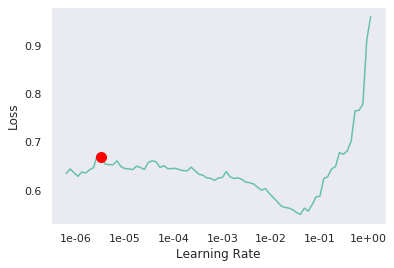

In [96]:
learn.lr_find() #Find the optimum learning rate to our dataset
learn.recorder.plot(suggestion=True)

We will take the learning rate with min loss and train our model

In [97]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.306492,0.512377,0.821380,03:51


In [98]:
# Now let's unfreeze the model
learn.unfreeze()
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.278828,0.499868,0.823770,10:38


In [0]:
# Save our encoder to use it later for classification
learn.save_encoder('ft_enc')

#### __Building a classifier__

In [100]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(vocab=data_lm.train_ds.vocab, train_df = train, valid_df = test, bs=32, path = "")
data_clas.save()
data_clas.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup g. xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @americanair xxmaj hi . i have xxup koa - xxup lax - xxup phl - xxup ord booked as a 1-way xxunk xxunk . xxmaj if i called to chnge it to xxup koa - xxup lax - xxup phx - xxup ord would i have to pay any fees,neutral
xxbos @united - xxup seriously it 's 2015 ? ! ? ! xxup no wifi on a 5hr flight from xxup cle - xxup sfo # xxunk . xxmaj you 're the xxup only airline w / out wifi ... and pls no ' xxunk ' xxup bs .,negative
"xxbos @southwestair i had to travel to xxmaj savannah , xxup xxunk , once again , on an airline i do n't "" xxmaj luv "" . xxmaj when r u going to fly me to xxmaj savannah ? xxmaj pl xxrep 4 e ase xxrep 4 !",neutral
xxbos @united xxup fail xxmaj you xxmaj cancelled xxmaj flightled our flight frm xxup xxunk and then used our reserv home to xxup iah ( from xxup sea ) for reflight xxmaj booking xxmaj problems w / out xxup our xxup permission ! ! # xxup ph6rps,negative


In [101]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11712 items)
x: TextList
xxbos @usairways why have me board a plane knowing there is a maint issue ? xxup us5235 .,xxbos @united is probably the least satisfactory airline i 've ever been on . xxmaj never fails to disappoint .,xxbos @virginamerica xxmaj beats xxup xxunk xxmaj views , xxmaj takes xxmaj on # southwestair xxup va xxup luv - xxmaj investor 's xxmaj business xxmaj daily http : / / t.co / xxunk,xxbos @southwestair my bag was xxmaj late xxmaj flight - checked and put on a different flight from xxup xxunk . xxmaj having troubles tracking it down . xxmaj any help ?,xxbos @united thank you for listening to my xxunk and doing the right thing . i appreciate you working with me
y: CategoryList
negative,negative,neutral,neutral,positive
Path: .;

Valid: LabelList (2928 items)
x: TextList
xxbos @southwestair i 'm in line at the airport right now . xxmaj will you cover hotel fair or am i to sleep in the airport ?,xxbos @jetblue yes

In [103]:
# train last layer
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.230640,0.579082,0.817964,03:15


In [104]:
# train last two layers
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.227555,0.570386,0.816598,03:54
1,0.168402,0.605445,0.821721,03:54


In [105]:
# train other layers
learn.unfreeze()
learn.fit_one_cycle(2, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.158324,0.622132,0.816257,10:40
1,0.138333,0.671488,0.811475,10:54


In [106]:
learn.predict('I love this airlines')

(Category positive, tensor(2), tensor([1.8361e-04, 1.6910e-06, 9.9981e-01]))

In [107]:
learn.predict('Horrible service, never again')

(Category negative, tensor(0), tensor([9.9980e-01, 1.0809e-04, 9.0207e-05]))

In [108]:
learn.predict('nothing special, just ordinary flight')

(Category neutral, tensor(1), tensor([0.2467, 0.7229, 0.0305]))

In [109]:
learn.show_results()

text,target,prediction
xxbos @united i xxup just xxup asked xxup my xxup boyfriend xxup to xxup xxunk xxup over xxup the xxup xxunk xxup on xxup flight xxunk xxup he xxup said xxup yes xxrep 4 ! xxup best xxup day xxup ever ! ! ! xxup thank u xxup so xxup much xxrep 6 !,positive,positive
xxbos @southwestair xxmaj the xxmaj fact xxmaj that u xxmaj see xxmaj black xxmaj history xxmaj month 12 xxmaj months a xxmaj year xxmaj is xxmaj xxunk ! xxmaj we xxup will xxup be xxmaj an xxmaj xxunk xxmaj base xxmaj for xxmaj xxunk xxmaj like u xxmaj in xxmaj future !,positive,neutral
"xxbos @usairways e xxrep 4 y ! xxmaj cancelled xxmaj flightlations , xxmaj flight xxmaj booking xxmaj problemss , reflight xxmaj booking xxmaj problemss , but y' all got me on the same flight out tonight ( not tomorrow ) & & the xxup fc upgrade . xxmaj thx !",positive,negative
xxbos @americanair xxmaj aww xxmaj thanks xxup aa .. xxup dfw was on xxup xxunk up here this xxup am .. so i understand .. xxmaj btw xxup xxunk is my xxmaj airline when i m able to xxunk .. xxmaj love you guys . : ),positive,positive
"xxbos @united xxmaj waiting for xxunk xxup ewr - xxup ord , delayed 47 mins . xxmaj might miss xxunk xxup ord - xxup xxunk at 6 pm xxup ct . xxmaj any room on xxunk xxup ord - xxup xxunk in case i miss xxunk ?",negative,negative


In [110]:
# Accuracy
interp = TextClassificationInterpretation.from_learner(learn)
acc = accuracy(interp.preds, interp.y_true)
print('Accuracy: {0:.3f}'.format(acc))

Accuracy: 0.811


### __Confusion matrix__

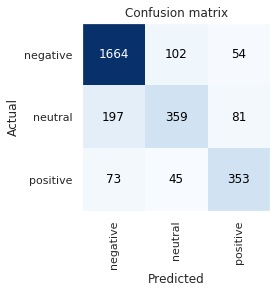

In [111]:
interp.plot_confusion_matrix()

From the confusion matrix we see that the model classifies accurate the negative tweets, although has some misclassification. For example, it classified 73 positive tweets as negative. However, the overall classification accuracy is quite high. 